In [12]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [13]:
%load_ext autoreload
%autoreload 2
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_class_path, HELMConverter
from node import MolSentenceNode #TODO: change after Filter implementation <- ?
from generator import MCTS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
config_path = "config/mcts_smiles.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_path, model_dir, lang_class_path, lang_path = (conf.get(k) for k in ("model_class_path", "model_dir", "lang_class_path", "lang_path"))
lang_class = get_class_from_class_path(lang_class_path)
lang = lang_class.load(repo_root + lang_path)
if lang_class_path.endswith("HELM"): #TODO: should be removed after .lang inclusion
    lang.converter = HELMConverter().load(repo_root + "data/helm/library/chembl_35_monomer_library.xml")
model_class = get_class_from_class_path(model_class_path)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_path, reward_conf = (conf.get(k) for k in ("reward_class_path", "reward_conf"))
reward_class = get_class_from_class_path(reward_class_path)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_path", "policy_conf"))
policy_class = get_class_from_class_path(policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = get_class_from_class_path(s.get("filter_class_path"))
    filters.append(filter_class(**s.get("filter_conf", {})))

Search is started.
0- time: 0.14, count_rollouts: 2, reward: 0.06353430466158744, node: O=C(C(=O)Oc1ccc(F)cc1)NC[C@@H]1CCO1
1- time: 0.28, count_rollouts: 3, reward: 0.23641929837044692, node: N#Cc1cccc([C@H]2CCCO2)c1
2- time: 0.36, count_rollouts: 4, reward: 0.07774280517836106, node: c1cccc(S(=O)(=O)NCCS(=O)(=O)N2CC[C@H]2CC)c1
3- time: 0.64, count_rollouts: 6, reward: 0.05844332320023999, node: [NH3+][C@@]1(Cc2ccccc2C1=O)[C@@H]1CCCO1
4- time: 0.74, count_rollouts: 7, reward: 0.062368941397111945, node: Clc1cc(S(=O)(=O)N2CCN(Cc3nnccc3)CC2)no1
5- time: 0.90, count_rollouts: 8, reward: 0.2932606424896942, node: S=C(Nc1ccc(CO)c(N)c1)Cc1cc(F)ccc1F
6- time: 1.17, count_rollouts: 10, reward: 0.40933241105529755, node: [C@H]S(=O)(=O)Nc1ccc(OCc2ccc(C(F)(F)F)cc2Cl)cc1
7- time: 1.34, count_rollouts: 11, reward: 0.1678747729870747, node: [C@@H]CSCCO[C@@H]1CCC[NH+](Cc2ccccc2)C1
8- time: 1.56, count_rollouts: 13, reward: 0.13636420278059985, node: [C@H]C[C@@H](C)[NH2+][C@H]1CCCCC1
9- time: 1.77, c

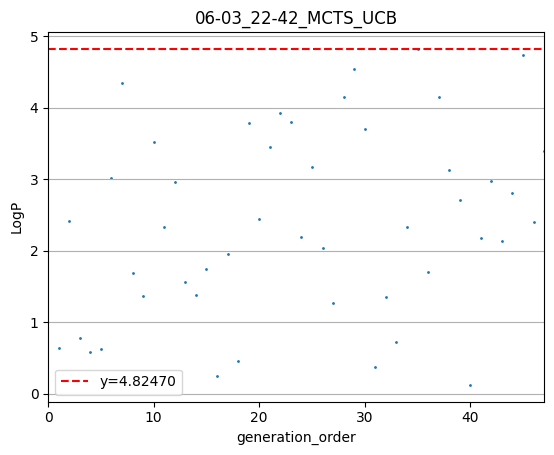

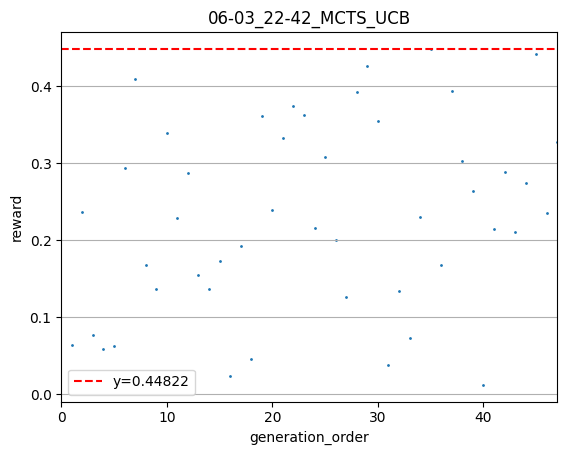

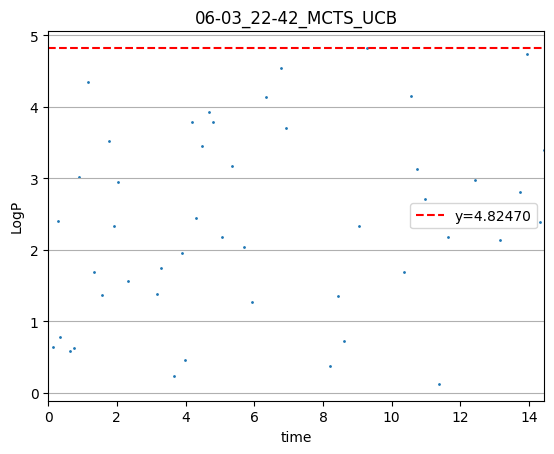

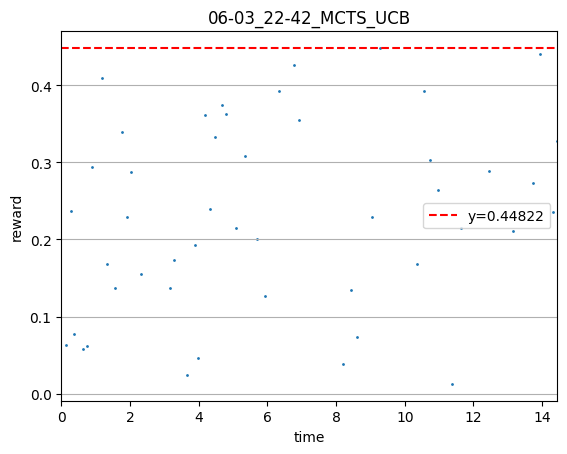

Search is completed.


In [22]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang)

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)